In [ ]:
import nltk
from nltk.corpus import treebank
import numpy as np
import os
import re
import pandas as pd
import seaborn as sns
import urllib.request
import zipfile
import progressbar
import tensorflow
from collections import defaultdict

from gensim.models import KeyedVectors

from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import progressbar
from IPython.display import display_html
from itertools import chain,cycle
# Downloading Glove Word Embeddings
pbar = None
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

# Display dataframes
def display(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: left;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

Da controllare.



#1.PreProcess


In [ ]:
nltk.download('treebank')

# Get the files' list
fileids = treebank.fileids()

treebank_corpus_complete = treebank.tagged_sents()
train_corpus = treebank.tagged_sents(fileids[:100])
val_corpus = treebank.tagged_sents(fileids[100:150])
test_corpus = treebank.tagged_sents(fileids[150:])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [ ]:
treebank_corpus_complete[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

##1.1 Divide in words(X) and tags(Y)
We do it for all the corpuses

In [ ]:
X = []
y = []

for sentence in treebank_corpus_complete:
  X_sentence = []
  y_sentence = []
  for entity in sentence:
    X_sentence.append(entity[0])
    y_sentence.append(entity[1])

  X.append(X_sentence)
  y.append(y_sentence)

In [ ]:
X_train = []
y_train = []

for sentence in train_corpus:
  X_sentence = []
  y_sentence = []
  for entity in sentence:
    X_sentence.append(entity[0])
    y_sentence.append(entity[1])

  X_train.append(X_sentence)
  y_train.append(y_sentence)

In [ ]:
X_val = []
y_val = []

for sentence in val_corpus:
  X_sentence = []
  y_sentence = []
  for entity in sentence:
    X_sentence.append(entity[0])
    y_sentence.append(entity[1])

  X_val.append(X_sentence)
  y_val.append(y_sentence)

In [ ]:
X_test = []
y_test = []

for sentence in test_corpus:
  X_sentence = []
  y_sentence = []
  for entity in sentence:
    X_sentence.append(entity[0])
    y_sentence.append(entity[1])

  X_test.append(X_sentence)
  y_test.append(y_sentence)

In [ ]:
#Create Dataframes for sentences

#Train
X_train_df = [[word, i] for i, sentence in enumerate(X_train) for word in sentence]
X_train_df = pd.DataFrame(X_train_df, columns = ['word','sentence'])
display(X_train_df.head())

#Val
X_val_df = [[word, i] for i, sentence in enumerate(X_val) for word in sentence]
X_val_df = pd.DataFrame(X_val_df, columns = ['word','sentence'])
display(X_val_df.head())

#Test
X_test_df = [[word, i] for i, sentence in enumerate(X_test) for word in sentence]
X_test_df = pd.DataFrame(X_test_df, columns = ['word','sentence'])
display(X_test_df.head())

,word,sentence
0,Pierre,0
1,Vinken,0
2,",",0
3,61,0
4,years,0


,word,sentence
0,A,0
1,House-Senate,0
2,conference,0
3,approved,0
4,major,0


,word,sentence
0,Intelogic,0
1,Trace,0
2,Inc.,0
3,",",0
4,San,0


In [ ]:
#Create Dataframes for tags

#Train
y_train_df = [[word, i] for i, sentence in enumerate(y_train) for word in sentence]
y_train_df = pd.DataFrame(y_train_df, columns = ['tag','sentence'])
display(X_train_df.head())

#Val
y_val_df = [[word, i] for i, sentence in enumerate(y_val) for word in sentence]
y_val_df = pd.DataFrame(y_val_df, columns = ['tag','sentence'])
display(y_val_df.head())

#Test
y_test_df = [[word, i] for i, sentence in enumerate(y_test) for word in sentence]
y_test_df = pd.DataFrame(y_test_df, columns = ['tag','sentence'])
display(y_test_df.head())

,word,sentence
0,Pierre,0
1,Vinken,0
2,",",0
3,61,0
4,years,0


,tag,sentence
0,DT,0
1,NNP,0
2,NN,0
3,VBD,0
4,JJ,0


,tag,sentence
0,NNP,0
1,NNP,0
2,NNP,0
3,",",0
4,NNP,0


In [ ]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in y for word in sentence]))
num_tags_train = len(set([word.lower() for word in y_train_df.tag]))
num_tags_test = len(set([word.lower() for word in y_test_df.tag]))
num_tags_val = len(set([word.lower() for word in y_val_df.tag]))


In [ ]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags Complete: {}".format(num_tags))
print("Total number of tags Train: {}".format(num_tags_train))
print("Total number of tags Test: {}".format(num_tags_test))
print("Total number of tags Val: {}".format(num_tags_val))

Total number of tagged sentences: 3914
Vocabulary size: 11387
Total number of tags Complete: 46
Total number of tags Train: 46
Total number of tags Test: 41
Total number of tags Val: 45


In [ ]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', y[0], '\n')
print('sample X train: ', X_train[0], '\n')
print('sample Y train: ', y_train[0], '\n')
print('sample X val: ', X_val[0], '\n')
print('sample Y val: ', y_val[0], '\n')
print('sample X test: ', X_test[0], '\n')
print('sample Y test: ', y_test[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

sample X train:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y train:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

sample X val:  ['A', 'House-Senate', 'conference', 'approved', 'major', 'portions', 'of', 'a', 'package', 'for', 'more', 'than', '$', '500', 'million', '*U*', 'in', 'economic', 'aid', 'for', 'Poland', 'that', '*T*-1', 'relies', 'heavily', 'on', '$', '240', 'million', '*U*', 'in', 'credit', 'and', 'loan', 'guarantees', 'in', 'fiscal', '1990', 'in', 'hopes', 'of', '*', 'stimulating', 'future', 'trade', 'and', 'investment', '.'] 

In [ ]:
#Vectorize X and y
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)
X_train_encoded = word_tokenizer.texts_to_sequences(X_train)
X_val_encoded = word_tokenizer.texts_to_sequences(X_val)
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
#Extract tags not present in test and val\n",
y_lab = [tag for sentence in y_train for tag in sentence]
y_t_lab  = list(set(y_lab))
y_lab = [tag for sentence in y_val for tag in sentence]
y_v_lab  =list(set(y_lab))
y_lab = [tag for sentence in y_test for tag in sentence]
y_te_lab  =list(set(y_lab))
ignore = [tags for tags in y_t_lab if tags not in y_v_lab or tags not in y_te_lab]

In [ ]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)
y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_val_encoded = tag_tokenizer.texts_to_sequences(y_val)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)
ignore_encoded = tag_tokenizer.texts_to_sequences(ignore)
ignore_encoded = [tag for sentence in ignore_encoded for tag in sentence]

In [ ]:
# look at first encoded data point

print("** Complete **", "\n", "-"*100, "\n")
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', y_encoded[0], '\n')

print("** Train **", "\n", "-"*100, "\n")
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_train[0], '\n')
print('Y: ', y_train[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_train_encoded[0], '\n')
print('Y: ', y_train_encoded[0], '\n')

print("** Validation **", "\n", "-"*100, "\n")
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_val[0], '\n')
print('Y: ', y_val[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_val_encoded[0], '\n')
print('Y: ', y_val_encoded[0], '\n')

print("** Test **", "\n", "-"*100, "\n")
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_test[0], '\n')
print('Y: ', y_test[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_test_encoded[0], '\n')
print('Y: ', y_test_encoded[0], '\n')

print("** Ignore **", "\n", "-"*100, "\n")
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', ignore, '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', ignore_encoded, '\n')

** Complete ** 
 ---------------------------------------------------------------------------------------------------- 

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3] 

Y:  [3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9] 

** Train ** 
 ---------------------------------------------------------------------------------------------------- 

** Raw data point ** 
 ---------------------------------------------------------------

In [ ]:
#check lengths

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded,y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

SyntaxError: ignored

#1.2 Pad sequences

In [ ]:
lengths = [len(seq) for seq in X]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


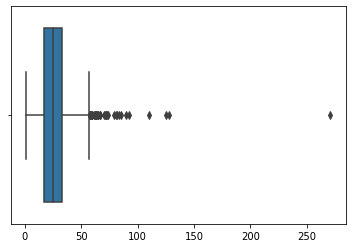

In [ ]:
sns.boxplot(lengths)

In [ ]:
from IPython.lib.pretty import MAX_SEQ_LENGTH
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Pad each sequence to max_seq_length using keras
#sentences longer than max_seq truncated
#sentences shorter padded with zeroes

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = max(lengths)

X_padded = pad_sequences(X_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')
y_padded = pad_sequences(y_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')

X_train_padded = pad_sequences(X_train_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')
y_train_padded = pad_sequences(y_train_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')

X_val_padded = pad_sequences(X_val_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')
y_val_padded = pad_sequences(y_val_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')

X_test_padded = pad_sequences(X_test_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')
y_test_padded = pad_sequences(y_test_encoded, maxlen = MAX_SEQ_LENGTH, padding = 'pre', truncating='post')

In [ ]:
# print the first sequence
print(X_padded[0], "\n")
print(y_padded[0], "\n")

# print the first sequence train
print(X_train_padded[0], "\n")
print(y_train_padded[0], "\n")

# print the first sequence val
print(X_val_padded[0], "\n")
print(y_val_padded[0], "\n")

# print the first sequence test
print(X_test_padded[0], "\n")
print(y_test_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
X,y = X_padded, y_padded
X_train, y_train = X_train_padded, y_train_padded
X_val, y_val = X_val_padded, y_val_padded
X_test, y_test = X_test_padded, y_test_padded

#2 Word Embeddings

Invece di creare il vocabolario con glove ed aggiungerci le oov del dataset, tratto glove come oov aggiungendolo al vocabolario delle parole del dataset


In [ ]:

# Download the GloVe embeddings file
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
urllib.request.urlretrieve(url, 'glove.6B.zip', show_progress)

# Extract the zip file
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall()
zip_ref.close()

100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:39 Time:  0:02:39


In [ ]:
#Use the 300 dimensional GLove Word Embeddings
glove_dir = './'
embedding_dim = 300
vocab_size = len(word_tokenizer.word_index) + 1
embedding_dict = {} #initialize dictionary
f = open(os.path.join(glove_dir, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_dict))
print('Vocab of size %s' % len(embedding_dict))

Found 400000 word vectors.
Vocab of size 400000


In [ ]:
embedding_weights = np.zeros((vocab_size,embedding_dim))
word2ind = word_tokenizer.word_index
for word, index in word2ind.items():
  try:
    embedding_weights[index, :] = embedding_dict[word]
  except KeyError:
    pass

In [ ]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (11388, 300)


In [ ]:
from nltk.tokenize import word_tokenize
embedding_weights[word_tokenizer.word_index['bottom']]

array([ 3.61680001e-01,  5.45570016e-01, -4.21449989e-01, -1.32129997e-01,
        1.43869996e-01,  3.33620012e-01, -1.68740004e-01, -1.52049996e-02,
        5.05720019e-01, -1.14370000e+00, -1.26359999e-01, -5.18639982e-02,
       -6.50840029e-02,  3.54719982e-02, -3.45279992e-01,  2.09189996e-01,
       -3.05170000e-01,  3.27719986e-01,  3.66230011e-01, -3.96120012e-01,
       -2.18559995e-01,  2.79549986e-01,  1.25749996e-02, -7.39459991e-02,
       -1.07630000e-01, -2.38110006e-01,  3.42689991e-01,  4.51849997e-01,
        2.59860000e-03,  1.32290006e-01,  1.43790007e-01,  1.45569995e-01,
        4.76429984e-02, -3.54240000e-01, -1.14040005e+00,  4.29199994e-01,
        3.10660005e-01, -1.34020001e-01,  7.56710023e-02,  4.42640007e-01,
        1.20920002e-01,  1.78749993e-01,  4.56500016e-02,  4.57439989e-01,
       -1.56560004e-01,  1.85450003e-01,  2.26889998e-01, -1.55049995e-01,
       -3.61490011e-01,  6.20420016e-02, -1.18060000e-01,  8.91269967e-02,
        1.61850005e-01, -

In [ ]:
y = to_categorical(y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test,47)
y_val = to_categorical(y_val,47)

In [ ]:
print(y.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3914, 271, 47)
(1963, 271, 47)
(1299, 271, 47)
(652, 271, 47)


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
#X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25)

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (1963, 271)
Shape of output sequences: (1963, 271, 47)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1299, 271)
Shape of output sequences: (1299, 271, 47)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (652, 271)
Shape of output sequences: (652, 271, 47)


In [ ]:
def ignore_class_accuracy(classes=[0]):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
        
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32')
        for to_ignore in classes:
          ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
          matches = matches * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [ ]:
# Define the model
baseline_model = Sequential(name='Baseline')

# Add the Embedding layer
# baseline_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
#                     weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))
baseline_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights=[embedding_weights], input_length=MAX_SEQ_LENGTH, trainable=True, mask_zero=True))

# Add the Bidirectional LSTM layer
baseline_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
baseline_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
baseline_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([*ignore_encoded])])


# Summary
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 271, 300)          3416400   
                                                                 
 bidirectional (Bidirectiona  (None, 271, 512)         1140736   
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 271, 47)          24111     
 ibuted)                                                         
                                                                 
Total params: 4,581,247
Trainable params: 4,581,247
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_baseline = baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val),batch_size=128, epochs=10)

Epoch 1/10
16/16 [==============================] - 33s 2s/step - loss: 0.2737 - accuracy: 0.2888 - ignore_accuracy: 0.0850 - val_loss: 0.2085 - val_accuracy: 0.4735 - val_ignore_accuracy: 0.0450
Epoch 2/10
16/16 [==============================] - 21s 1s/step - loss: 0.1651 - accuracy: 0.5774 - ignore_accuracy: 0.0552 - val_loss: 0.1207 - val_accuracy: 0.6843 - val_ignore_accuracy: 0.0650
Epoch 3/10
16/16 [==============================] - 21s 1s/step - loss: 0.0933 - accuracy: 0.7597 - ignore_accuracy: 0.0726 - val_loss: 0.0755 - val_accuracy: 0.7973 - val_ignore_accuracy: 0.0757
Epoch 4/10
16/16 [==============================] - 21s 1s/step - loss: 0.0589 - accuracy: 0.8455 - ignore_accuracy: 0.0808 - val_loss: 0.0537 - val_accuracy: 0.8538 - val_ignore_accuracy: 0.0811
Epoch 5/10
16/16 [==============================] - 21s 1s/step - loss: 0.0406 - accuracy: 0.8937 - ignore_accuracy: 0.0855 - val_loss: 0.0420 - val_accuracy: 0.8843 - val_ignore_accuracy: 0.0840
Epoch 6/10
16/16 [==

In [ ]:
scores = baseline_model.evaluate(X_test, y_test, return_dict = True)

21/21 [==============================] - 3s 135ms/step - loss: 0.0221 - accuracy: 0.9327 - ignore_accuracy: 0.0888


In [ ]:
predictions = baseline_model.predict(X_test)

21/21 [==============================] - 5s 130ms/step


In [ ]:
# Convert the class probabilities into class labels
predicted_labels = np.argmax(predictions, axis=-1)

true_pos = defaultdict(int)
false_pos = defaultdict(int)
false_neg = defaultdict(int)
precision = defaultdict(float)
recall = defaultdict(float)
f1score = defaultdict(float)


for tag in y_te_lab:
  if tag not in ignore:
    for idx_sentence in range(len(y_test_encoded)):
      for idx_word in range(len(y_test_encoded[idx_sentence])):
        if y_test_encoded[idx_sentence][idx_word] == tag_tokenizer.texts_to_sequences(tag):
          if predicted_labels[idx_sentence][idx_word] == y_test[idx_sentence][idx_word]:
               true_pos[y_test_encoded[idx_sentence][idx_word]] += 1
          else:
          # If the predicted tag does not match ground truth we increase false negative count for that tag
          # and false positive count for the wrongly predicted tag
            false_neg[y_test_encoded[idx_sentence][idx_word]] += 1
            false_pos[predicted_labels[idx_sentence][idx_word][idx_word]] += 1
    # We then compute precision, recall and F1 scores
    if true_pos[tag] != 0:
      precision[tag] = true_pos[tag] / (true_pos[tag] + false_pos[tag])
      recall[tag] = true_pos[tag] / (true_pos[tag] + false_neg[tag])
      f1score[tag] = 2 * ((precision[tag] * recall[tag]) / (precision[tag] + recall[tag])) 
    else:
      print(tag)
      print(true_pos[tag])
      print(false_pos[tag])
      print(false_neg[tag])
      print()

PDT
0
0
0

NN
0
0
0

VBP
0
0
0

DT
0
0
0

:
0
0
0

RBS
0
0
0

''
0
0
0

CC
0
0
0

JJS
0
0
0

WRB
0
0
0

PRP$
0
0
0

``
0
0
0

TO
0
0
0

JJ
0
0
0

WP
0
0
0

WP$
0
0
0

VBD
0
0
0

RBR
0
0
0

MD
0
0
0

NNS
0
0
0

NNP
0
0
0

VBZ
0
0
0

RB
0
0
0

RP
0
0
0

POS
0
0
0

VBG
0
0
0

VB
0
0
0

VBN
0
0
0

,
0
0
0

-RRB-
0
0
0

PRP
0
0
0

-LRB-
0
0
0

NNPS
0
0
0

CD
0
0
0

JJR
0
0
0

-NONE-
0
0
0

.
0
0
0

EX
0
0
0

WDT
0
0
0

IN
0
0
0

$
0
0
0



In [ ]:
for tag in y_te_lab:
  if tag not in ignore:
    print(f'Tag: {tag}')
    print(f'\tPrecision: {precision[tag]}')
    print(f'\tRecall: {recall[tag]}')
    print(f'\tF1-score: {f1score[tag]}')

Tag: PDT
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: NN
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: VBP
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: DT
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: :
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: RBS
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: ''
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: CC
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: JJS
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: WRB
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: PRP$
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: ``
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: TO
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: JJ
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: WP
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: WP$
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: VBD
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: RBR
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: MD
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag

In [ ]:
provola = [el[1] for el in f1score.items()]

sum = 0

for p in provola:
  sum += p

print(f'MACRO F1-score: {sum / len(f1score.items())}')

MACRO F1-score: 0.0


In [ ]:
from sklearn.metrics import f1_score
# Flatten the predictions and the true labels to 1D arrays
predictions = predictions.flatten()
y_true = y_test.flatten()

print(predictions)
th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_baseline = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_baseline,3))

baseline_model.save('./baseline_model')

[2.0994846e-02 2.1621110e-02 2.1324312e-02 ... 9.4370756e-07 3.6169158e-07
 3.3871888e-07]
Macro-F1 score: 0.577


#GRU



In [ ]:
# Define the model
gru_model = tensorflow.keras.Sequential(name='GRU')

# Add the Embedding layer
gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the GRU layer
gru_model.add(GRU(units=128, return_sequences=True))

# Add the Dense/Fully-Connected layer
gru_model.add(TimeDistributed(Dense(47, activation='softmax')))

# Compile the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([*ignore_encoded])])

# Summary
gru_model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 271, 300)          3416400   
                                                                 
 gru (GRU)                   (None, 271, 128)          165120    
                                                                 
 time_distributed_2 (TimeDis  (None, 271, 47)          6063      
 tributed)                                                       
                                                                 
Total params: 3,587,583
Trainable params: 3,587,583
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_gru = gru_model.fit(X_train, y_train, epochs=10, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/10
16/16 [==============================] - 6s 78ms/step - loss: 2.9663 - accuracy: 0.9171 - ignore_accuracy: 0.9173 - val_loss: 0.4003 - val_accuracy: 0.9133 - val_ignore_accuracy: 0.9146
Epoch 2/10
16/16 [==============================] - 1s 38ms/step - loss: 0.3991 - accuracy: 0.9149 - ignore_accuracy: 0.9150 - val_loss: 0.3170 - val_accuracy: 0.9233 - val_ignore_accuracy: 0.9244
Epoch 3/10
16/16 [==============================] - 1s 38ms/step - loss: 0.2861 - accuracy: 0.9294 - ignore_accuracy: 0.9300 - val_loss: 0.2560 - val_accuracy: 0.9409 - val_ignore_accuracy: 0.9419
Epoch 4/10
16/16 [==============================] - 1s 38ms/step - loss: 0.2394 - accuracy: 0.9476 - ignore_accuracy: 0.9478 - val_loss: 0.2238 - val_accuracy: 0.9534 - val_ignore_accuracy: 0.9545
Epoch 5/10
16/16 [==============================] - 1s 38ms/step - loss: 0.2063 - accuracy: 0.9565 - ignore_accuracy: 0.9567 - val_loss: 0.1927 - val_accuracy: 0.9601 - val_ignore_accuracy: 0.9610
Epoch 6/10
16/1

In [ ]:
y_pred = gru_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_gru = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_gru,3))

gru_model.save('./gru_model')

21/21 [==============================] - 0s 6ms/step
Macro-F1 score: 0.981


#Additional LSTM Layer

In [ ]:
# Define the model
add_lstm_model = tensorflow.keras.Sequential(name='Additional_LSTM')

# Add the Embedding layer
add_lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the Bidirectional LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add another LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add the Dense/Fully-Connected layer
add_lstm_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
add_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([*ignore_encoded])])

# Summary
add_lstm_model.summary()

Model: "Additional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 271, 300)          3416400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 271, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 271, 256)         394240    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 271, 47)          12079     
 tributed)                                                       
                                                                 
Total params: 4,262,015
Trainable params: 4,262,015
Non-trainable params: 0
_________________________________________

In [ ]:
results_add_lstm = add_lstm_model.fit(X_train, y_train, epochs=15, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/15
16/16 [==============================] - 9s 220ms/step - loss: 1.6599 - accuracy: 0.8856 - ignore_accuracy: 0.8868 - val_loss: 0.3189 - val_accuracy: 0.9145 - val_ignore_accuracy: 0.9159
Epoch 2/15
16/16 [==============================] - 2s 127ms/step - loss: 0.3013 - accuracy: 0.9157 - ignore_accuracy: 0.9156 - val_loss: 0.2915 - val_accuracy: 0.9175 - val_ignore_accuracy: 0.9187
Epoch 3/15
16/16 [==============================] - 2s 127ms/step - loss: 0.2875 - accuracy: 0.9199 - ignore_accuracy: 0.9195 - val_loss: 0.2829 - val_accuracy: 0.9214 - val_ignore_accuracy: 0.9227
Epoch 4/15
16/16 [==============================] - 2s 126ms/step - loss: 0.2793 - accuracy: 0.9223 - ignore_accuracy: 0.9223 - val_loss: 0.2753 - val_accuracy: 0.9266 - val_ignore_accuracy: 0.9278
Epoch 5/15
16/16 [==============================] - 2s 126ms/step - loss: 0.2704 - accuracy: 0.9273 - ignore_accuracy: 0.9275 - val_loss: 0.2648 - val_accuracy: 0.9308 - val_ignore_accuracy: 0.9319
Epoch 6/15

In [ ]:
y_pred = add_lstm_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_add_lstm = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_add_lstm,3))

add_lstm_model.save('./add_lstm_model')

21/21 [==============================] - 2s 25ms/step
Macro-F1 score: 0.988


#Additional Dense Layer

In [ ]:
# Define the model
add_fc_model = tensorflow.keras.Sequential(name='Additional_FC')

# Add the Embedding layer
add_fc_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                    weights = [embedding_weights], input_length = MAX_SEQ_LENGTH, trainable=True))

# Add the Bidirectional LSTM layer
add_fc_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))

# Add another Dense layer
add_fc_model.add(TimeDistributed(Dense(units=MAX_SEQ_LENGTH, activation='relu')))

# Add the Dense/Fully-Connected layer
add_fc_model.add(TimeDistributed(Dense(units=47, activation='softmax')))

# Compile the model
add_fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([*ignore_encoded])])

# Summary
add_fc_model.summary()

Model: "Additional_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 271, 300)          3416400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 271, 256)         439296    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 271, 271)         69647     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 271, 47)          12784     
 tributed)                                                       
                                                                 
Total params: 3,938,127
Trainable params: 3,938,127
Non-trainable params: 0
___________________________________________

In [ ]:
results_add_fc = add_fc_model.fit(X_train, y_train, epochs=15, verbose = True, validation_data=(X_val,y_val), batch_size=128)

Epoch 1/15
16/16 [==============================] - 5s 139ms/step - loss: 2.1903 - accuracy: 0.8939 - ignore_accuracy: 0.8948 - val_loss: 0.3033 - val_accuracy: 0.9179 - val_ignore_accuracy: 0.9191
Epoch 2/15
16/16 [==============================] - 1s 79ms/step - loss: 0.2889 - accuracy: 0.9286 - ignore_accuracy: 0.9286 - val_loss: 0.2679 - val_accuracy: 0.9308 - val_ignore_accuracy: 0.9319
Epoch 3/15
16/16 [==============================] - 1s 79ms/step - loss: 0.2515 - accuracy: 0.9373 - ignore_accuracy: 0.9376 - val_loss: 0.2302 - val_accuracy: 0.9442 - val_ignore_accuracy: 0.9452
Epoch 4/15
16/16 [==============================] - 1s 80ms/step - loss: 0.2076 - accuracy: 0.9485 - ignore_accuracy: 0.9488 - val_loss: 0.1835 - val_accuracy: 0.9525 - val_ignore_accuracy: 0.9535
Epoch 5/15
16/16 [==============================] - 1s 80ms/step - loss: 0.1616 - accuracy: 0.9572 - ignore_accuracy: 0.9573 - val_loss: 0.1425 - val_accuracy: 0.9621 - val_ignore_accuracy: 0.9628
Epoch 6/15
16/

In [ ]:
y_pred = add_fc_model.predict(X_test)
# Flatten the predictions and the true labels to 1D arrays
predictions = y_pred.flatten()
y_true = y_test.flatten()

th = 0.1
predictions[predictions >= th] = 1 
predictions[predictions  < th] = 0

# Compute the F1 score
f1_add_fc = f1_score(y_true, predictions, average = 'macro')

print("Macro-F1 score:", round(f1_add_fc,3))

add_fc_model.save('./add_fc_model')

21/21 [==============================] - 1s 13ms/step
Macro-F1 score: 0.992


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# # Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_baseline.history['val_accuracy'])+1))

# # Create a Plotly line plot using the epochs and validation accuracy data
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=results_baseline.history['val_accuracy'], name='Baseline - BiLSTM Model', mode='lines+markers'))
fig.add_trace(go.Scatter(x=epochs, y=results_gru.history['val_accuracy'], name='GRU Model', mode='lines+markers'))
fig.show()

# Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_add_lstm.history['val_accuracy'])+1))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=epochs, y=results_add_lstm.history['val_accuracy'], name='2 BiLSTMs Model', mode='lines+markers'))
fig2.add_trace(go.Scatter(x=epochs, y=results_add_fc.history['val_accuracy'], name='2 FCs Model', mode='lines+markers'))
fig2.show()

max_width = max(len(str(f1_baseline)), len(str(f1_gru)), len(str(f1_add_lstm)), len(str(f1_add_fc)))

header_row = f'| F1 Score Baseline {" " * (max_width - len("F1 Score Baseline"))} | F1 Score GRU {" " * (max_width - len("F1 Score GRU"))} |\
 F1 Score Add. BiLSTM {" " * (max_width - len("F1 Score Add. BiLSTM"))} | F1 Score Add. Dense {" " * (max_width - len("F1 Score Add. Dense"))} |'
separator_row = '-' * len(header_row)
data_row = f'| {f1_baseline:<{max_width}} | {f1_gru:<{max_width}} | {f1_add_lstm:<{max_width}} | {f1_add_fc:<{max_width}} |'

print(header_row)
print(separator_row)
print(data_row)

| F1 Score Baseline   | F1 Score GRU        | F1 Score Add. BiLSTM  | F1 Score Add. Dense  |
--------------------------------------------------------------------------------------------
| 0.5773874728575583 | 0.9809876536929896 | 0.9879542437390483 | 0.9923407445251189 |
